1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


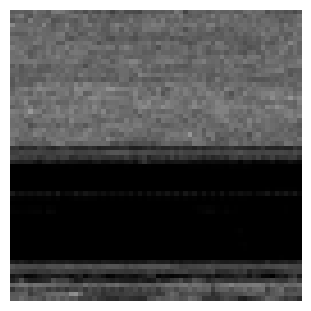

In [2]:
import os
import numpy as np
from math import log
from PIL import Image
import tkinter as tk
from tkinter import filedialog, Label, Button
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow.keras.backend as K

# Director temporar pentru fișierele convertite
temp_dir = './temp/'
os.makedirs(temp_dir, exist_ok=True)

# Metrici personalizate pentru model (modifică dacă este nevoie)
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Încarcă modelul (modifică calea dacă e necesar)
model_path = 'my_model.h5'
model = load_model(model_path, custom_objects={'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})

# Lista claselor de malware
malware_classes = [
    "Adialer.C", "Agent.FYI", "Allaple.A", "Allaple.L", "Alueron.gen!J",
    "Autorun.K", "C2LOP.P", "C2LOP.gen!g", "Dialplatform.B", "Dontovo.A",
    "Fakerean", "Instantaccess", "Lolyda.AA1", "Lolyda.AA2", "Lolyda.AA3",
    "Lolyda.AT", "Malex.gen!J", "Obfuscator.AD", "Rbot!gen", "Skintrim.N",
    "Swizzor.gen!E", "Swizzor.gen!I", "VB.AT", "Wintrim.BX", "Yuner.A"
]

# Funcție pentru conversia fișierelor binare la format `.bytes`
def convert_to_bytes(filepath):
    with open(filepath, 'rb') as f:
        binary_content = f.read()

    hex_lines = []
    for i in range(0, len(binary_content), 16):
        line = ' '.join(f'{b:02x}' for b in binary_content[i:i+16])
        hex_lines.append(f"{i:08x} {line}")

    bytes_filepath = os.path.join(temp_dir, 'temp.bytes')
    with open(bytes_filepath, 'w') as f:
        f.write('\n'.join(hex_lines))

    return bytes_filepath

# Funcție pentru conversia unui fișier .bytes într-o imagine PNG
def convert_and_save(array, name):
    if array.shape[1] != 16:
        raise ValueError("Format incorect. Fișierul trebuie să aibă 16 valori pe linie.")

    b = int((array.shape[0] * 16) ** 0.5)
    b = 2 ** (int(log(b) / log(2)) + 1)
    a = int(array.shape[0] * 16 / b)

    array = array[:a * b // 16, :]
    array = np.reshape(array, (a, b, 1))  # RGB conversie
    array = np.repeat(array, 3, axis=2)  # Convertim la RGB

    im = Image.fromarray(np.uint8(array))
    im = im.resize((64, 64))
    png_filepath = os.path.join(temp_dir, name + '.png')
    im.save(png_filepath, "PNG")
    return png_filepath

# Funcția principală pentru conversia și prelucrarea fișierului
def process_file(filepath):
    if filepath.endswith('.png') and len(os.path.basename(filepath).split('.')[0]) == 32:
        return filepath
    bytes_filepath = convert_to_bytes(filepath)

    array = []
    with open(bytes_filepath, 'r') as f:
        for line in f:
            parts = line.split()
            if len(parts) != 17:
                continue
            array.append([int(value, 16) if value != '??' else 0 for value in parts[1:]])

    image_path = convert_and_save(np.array(array), 'temp_image')
    return image_path

# Funcția pentru a încărca fișierul și a face predicția
def load_and_predict():
    filepath = filedialog.askopenfilename()
    try:
        image_path = process_file(filepath)

        # Preprocesăm imaginea manual
        img = load_img(image_path, target_size=(64, 64))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Adaugă dimensiunea lotului
        img_array /= 255.0  # Rescalăm valorile între 0 și 1

        # Facem predicția
        predictions = model.predict(img_array)
        result_text = "\n".join([f"{malware_classes[i]}: {round(p * 100, 2)}%" for i, p in enumerate(predictions[0])])
        result_label.config(text=result_text)

        # Afișăm imaginea byte stream
        display_image(image_path)

    except Exception as e:
        result_label.config(text=f"Eroare: {e}")

# Funcție pentru a afișa imaginea în interfață
def display_image(image_path):
    img = Image.open(image_path)
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.axis('off')

    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().pack(pady=10)

# Configurare interfață
root = tk.Tk()
root.title("Predictie pe baza fișierului încărcat")

load_button = Button(root, text="Încarcă fișier", command=load_and_predict)
load_button.pack(pady=10)

result_label = Label(root, text="")
result_label.pack(pady=10)

root.mainloop()
